In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import os
import torchvision.datasets as dset
from data import image_manipulation
from data import dataloader as img_dataloader
from torch.autograd import Variable
from tqdm import tqdm
from PIL import Image

torch.cuda.is_available()

True

In [2]:
# random seed for reproducibility
random_seed = 69

np.random.seed(random_seed)

In [3]:
# no of workers for dataloader
no_of_workers = 4

# root of the data
data_root = "data/train/"

# batch size
batch_size = 1

#no of epochs
n_epochs = 10

# learning rate
lr = 0.0002

# betas for adam
beta_1 = 0.5
beta_2 = 0.999

# image size
image_height = 256
image_width = 256

In [4]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataset = dset.ImageFolder(root=data_root,
                           transform=transforms.Compose([
                               transforms.ToTensor(),
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True,
                                         num_workers = no_of_workers)

In [5]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

In [6]:
class UNetDown(nn.Module):
    def __init__(self, in_size, out_size, normalize = True, dropout = 0.0):
        super(UNetDown, self).__init__()
        layers = [
            nn.Conv2d(in_size, out_size, 4, 2, 1, bias = False)
        ]
        if normalize:
            layers.append(nn.InstanceNorm2d(out_size))
            
        layers.append(nn.LeakyReLU(0.2))
        
        if dropout:
            layers.append(nn.Dropout(dropout))
            
        self.model = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.model(x)

In [7]:
class UNetUp(nn.Module):
    def __init__(self, in_size, out_size, dropout = 0.0):
        super(UNetUp, self).__init__()

        layers = [
            nn.ConvTranspose2d(in_size, out_size, 4, 2, 1, bias=False),
            nn.InstanceNorm2d(out_size),
            nn.ReLU(inplace=True),
        ]
        if dropout:
            layers.append(nn.Dropout(dropout))

        self.model = nn.Sequential(*layers)
        
    
    def forward(self, x, skip_input):
        x = self.model(x)
        x = torch.cat((x, skip_input), 1)

        return x

In [8]:
class GeneratorUNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3):
        super(GeneratorUNet, self).__init__()
        
        self.down1 = UNetDown(in_channels, 64, normalize=False)
        self.down2 = UNetDown(64, 128)
        self.down3 = UNetDown(128, 256)
        self.down4 = UNetDown(256, 512, dropout=0.5)
        self.down5 = UNetDown(512, 512, dropout=0.5)
        self.down6 = UNetDown(512, 512, dropout=0.5)
        self.down7 = UNetDown(512, 512, dropout=0.5)
        self.down8 = UNetDown(512, 512, normalize=False, dropout=0.5)

        self.up1 = UNetUp(512, 512, dropout=0.5)
        self.up2 = UNetUp(1024, 512, dropout=0.5)
        self.up3 = UNetUp(1024, 512, dropout=0.5)
        self.up4 = UNetUp(1024, 512, dropout=0.5)
        self.up5 = UNetUp(1024, 256)
        self.up6 = UNetUp(512, 128)
        self.up7 = UNetUp(256, 64)

        self.final = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(128, out_channels, 4, padding=1),
            nn.Tanh(),
        )

    def forward(self, x):
        # U-Net generator with skip connections from encoder to decoder
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)
        d6 = self.down6(d5)
        d7 = self.down7(d6)
        d8 = self.down8(d7)
        u1 = self.up1(d8, d7)
        u2 = self.up2(u1, d6)
        u3 = self.up3(u2, d5)
        u4 = self.up4(u3, d4)
        u5 = self.up5(u4, d3)
        u6 = self.up6(u5, d2)
        u7 = self.up7(u6, d1)

        return self.final(u7)

In [9]:
class Discriminator(nn.Module):
    def __init__(self, in_channels=3):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, normalization=True):
            """Returns downsampling layers of each discriminator block"""
            layers = [nn.Conv2d(in_filters, out_filters, 4, stride=2, padding=1)]
            if normalization:
                layers.append(nn.InstanceNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *discriminator_block(in_channels * 2, 64, normalization=False),
            *discriminator_block(64, 128),
            *discriminator_block(128, 256),
            *discriminator_block(256, 512),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(512, 1, 4, padding=1, bias=False)
        )

    def forward(self, img_A, img_B):
        # Concatenate image and condition image by channels to produce input
        img_input = torch.cat((img_A, img_B), 1)
        return self.model(img_input)

## Model Train

In [10]:
#initialize model classes
generator = GeneratorUNet()
discriminator = Discriminator()


# cuda
cuda = True if torch.cuda.is_available() else False
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(cuda)

# initialize weights
if os.path.exists("saved_models/generator.pth"):
    print("Generator Found")
    generator.load_state_dict(torch.load("saved_models/generator.pth", map_location = device))
else:
    generator.apply(weights_init_normal)
                                         
if os.path.exists("saved_models/discriminator.pth"):
    print("Discriminator Found")
    discriminator.load_state_dict(torch.load("saved_models/discriminator.pth", map_location = device))
else:
    discriminator.apply(weights_init_normal)

# model loss functions
loss_fn_generator = torch.nn.MSELoss()
loss_fn_disc = torch.nn.L1Loss() #pixel wise loss

# to cuda if cuda is avaiable
generator.to(device)
discriminator.to(device)
loss_fn_disc.to(device)
loss_fn_generator.to(device)
    
# optimizers
optimier_G = torch.optim.Adam(generator.parameters(), betas=(beta_1, beta_2), lr=lr)
optimier_D = torch.optim.Adam(discriminator.parameters(), betas=(beta_1, beta_2), lr=lr)

# Loss weight of L1 pixel-wise loss between translated image and real image
lambda_pixel = 50

# Calculate output of image discriminator (PatchGAN)
patch = (1, image_height // 2 ** 4, image_width // 2 ** 4)

# Tensor type
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

True
Generator Found
Discriminator Found


In [11]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((image_width, image_height))
])

pair_image_dataloader = img_dataloader.ImageDataset("./data/train/old_images", "./data/train/reconstructed_images", transform)

In [12]:
for epoch in range(1):
    for i, batch in tqdm(enumerate(pair_image_dataloader)):
        real_A = batch['A'] # old image
        real_B = batch['B'] # new image
        
        # train generator
        optimier_G.zero_grad()
        
         # Adversarial ground truths
        valid = Variable(Tensor(np.ones((real_A.size(0), *patch))), requires_grad=False)
        fake = Variable(Tensor(np.zeros((real_A.size(0), *patch))), requires_grad=False)
        
        
        # GAN loss
        fake_B = generator(real_A.unsqueeze(0).to(device)) # fake sample generated by generator
        pred_fake = discriminator(fake_B.to(device), real_B.unsqueeze(0).to(device)) # prediction using discriminator
        loss_generator = loss_fn_generator(pred_fake.to(device), valid.to(device)) # check if the sample is valid or not
        
        loss_pixel = loss_fn_disc(fake_B.to(device), real_B.to(device)) # calculate the pixel wise loss
        
        # total loss
        loss_G = loss_generator + lambda_pixel * loss_pixel
        
        loss_G.backward()
        optimier_G.step()
        
        ## Train discriminator
        optimier_D.zero_grad()
        
        # Real loss
        pred_real = discriminator(real_B.unsqueeze(0).to(device), real_A.unsqueeze(0).to(device))
        loss_real = loss_fn_generator(pred_real, valid)

        # Fake loss
        pred_fake = discriminator(fake_B.detach().to(device), real_A.unsqueeze(0).to(device))
        loss_fake = loss_fn_generator(pred_fake.to(device), fake.to(device))

        # Total loss
        loss_D = 0.5 * (loss_real + loss_fake)
        
        loss_D.backward()
        optimier_D.step()
        
        if i % 100 == 0 and i:
            print(f"Error: {torch.linalg.norm(loss_G).item()}, epoch: {epoch}, itr: {i}")
        if i % 5000 ==  0 and i > 0:
            break

0it [00:00, ?it/s]C:\Users\rupes\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([3, 1, 16, 16])) that is different to the input size (torch.Size([1, 1, 16, 16])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\rupes\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:96: UserWarning: Using a target size (torch.Size([3, 256, 256])) that is different to the input size (torch.Size([1, 3, 256, 256])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
103it [00:11, 13.04it/s]

Error: 4.68488883972168, epoch: 0, itr: 100


203it [00:18, 13.04it/s]

Error: 5.06247615814209, epoch: 0, itr: 200


303it [00:26, 12.80it/s]

Error: 4.506854057312012, epoch: 0, itr: 300


403it [00:34, 12.79it/s]

Error: 4.3066511154174805, epoch: 0, itr: 400


503it [00:42, 12.63it/s]

Error: 3.7834036350250244, epoch: 0, itr: 500


603it [00:49, 12.85it/s]

Error: 4.458029747009277, epoch: 0, itr: 600


703it [00:57, 12.82it/s]

Error: 2.391383409500122, epoch: 0, itr: 700


803it [01:05, 12.79it/s]

Error: 3.4615674018859863, epoch: 0, itr: 800


903it [01:13, 12.73it/s]

Error: 4.403113842010498, epoch: 0, itr: 900


1003it [01:21, 12.77it/s]

Error: 4.409789562225342, epoch: 0, itr: 1000


1103it [01:28, 12.63it/s]

Error: 3.6542210578918457, epoch: 0, itr: 1100


1203it [01:36, 12.82it/s]

Error: 3.145620107650757, epoch: 0, itr: 1200


1303it [01:44, 12.61it/s]

Error: 4.407347679138184, epoch: 0, itr: 1300


1403it [01:52, 12.83it/s]

Error: 3.44026517868042, epoch: 0, itr: 1400


1503it [02:00, 12.72it/s]

Error: 3.6039319038391113, epoch: 0, itr: 1500


1603it [02:08, 12.57it/s]

Error: 4.321276664733887, epoch: 0, itr: 1600


1703it [02:16, 12.42it/s]

Error: 3.7542717456817627, epoch: 0, itr: 1700


1803it [02:24, 11.82it/s]

Error: 4.005212783813477, epoch: 0, itr: 1800


1903it [02:32, 12.48it/s]

Error: 2.790297031402588, epoch: 0, itr: 1900


2003it [02:40, 12.44it/s]

Error: 2.7658185958862305, epoch: 0, itr: 2000


2103it [02:48, 12.52it/s]

Error: 3.383143424987793, epoch: 0, itr: 2100


2203it [02:56, 12.44it/s]

Error: 5.566417694091797, epoch: 0, itr: 2200


2303it [03:04, 12.67it/s]

Error: 3.448906183242798, epoch: 0, itr: 2300


2403it [03:12, 12.50it/s]

Error: 2.9735262393951416, epoch: 0, itr: 2400


2503it [03:20, 12.26it/s]

Error: 3.092679023742676, epoch: 0, itr: 2500


2603it [03:28, 12.58it/s]

Error: 6.130992889404297, epoch: 0, itr: 2600


2703it [03:36, 12.51it/s]

Error: 4.377227783203125, epoch: 0, itr: 2700


2803it [03:44, 12.53it/s]

Error: 4.125698089599609, epoch: 0, itr: 2800


2903it [03:52, 12.35it/s]

Error: 4.5966081619262695, epoch: 0, itr: 2900


3003it [04:00, 12.47it/s]

Error: 3.3026821613311768, epoch: 0, itr: 3000


3103it [04:08, 12.48it/s]

Error: 4.710966110229492, epoch: 0, itr: 3100


3203it [04:16, 12.35it/s]

Error: 4.194236755371094, epoch: 0, itr: 3200


3303it [04:24, 12.45it/s]

Error: 3.431500196456909, epoch: 0, itr: 3300


3403it [04:32, 12.54it/s]

Error: 3.704583168029785, epoch: 0, itr: 3400


3503it [04:40, 12.46it/s]

Error: 4.235966682434082, epoch: 0, itr: 3500


3603it [04:48, 12.53it/s]

Error: 4.188169479370117, epoch: 0, itr: 3600


3703it [04:56, 12.51it/s]

Error: 3.529012680053711, epoch: 0, itr: 3700


3803it [05:04, 12.35it/s]

Error: 3.3598008155822754, epoch: 0, itr: 3800


3903it [05:13, 12.41it/s]

Error: 4.124131202697754, epoch: 0, itr: 3900


4003it [05:21, 12.20it/s]

Error: 3.626267910003662, epoch: 0, itr: 4000


4103it [05:29, 12.12it/s]

Error: 3.9751241207122803, epoch: 0, itr: 4100


4203it [05:37, 12.25it/s]

Error: 2.147571325302124, epoch: 0, itr: 4200


4303it [05:45, 12.37it/s]

Error: 4.006787300109863, epoch: 0, itr: 4300


4403it [05:53, 12.60it/s]

Error: 3.5976269245147705, epoch: 0, itr: 4400


4503it [06:01, 12.59it/s]

Error: 3.1226437091827393, epoch: 0, itr: 4500


4603it [06:09, 12.60it/s]

Error: 3.8590636253356934, epoch: 0, itr: 4600


4703it [06:17, 12.50it/s]

Error: 4.665069103240967, epoch: 0, itr: 4700


4803it [06:25, 12.51it/s]

Error: 3.53623104095459, epoch: 0, itr: 4800


4903it [06:33, 12.49it/s]

Error: 4.3289289474487305, epoch: 0, itr: 4900


5000it [06:41, 12.47it/s]

Error: 3.379643201828003, epoch: 0, itr: 5000


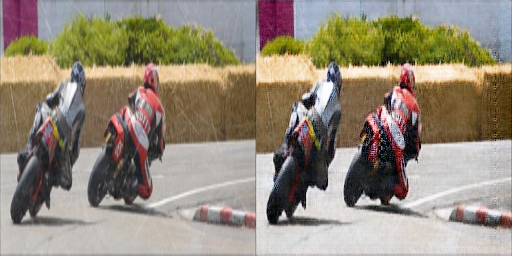

In [23]:
test_image_index = 5259

output_image = image_manipulation.np_to_pil(
    generator(pair_image_dataloader[test_image_index]['A'].unsqueeze(0).to(device)).detach().cpu().numpy()[0]
)

original_image = image_manipulation.np_to_pil(
    pair_image_dataloader[test_image_index]['A'].detach().cpu().numpy()
)

new_image = Image.new(output_image.mode, (512, 256))

new_image.paste(original_image, (0, 0))
new_image.paste(output_image, (256, 0))

new_image

In [21]:
torch.save(generator.state_dict(), "saved_models/generator.pth")
torch.save(discriminator.state_dict(), "saved_models/discriminator.pth")

In [95]:
os.path.exists("saved_models/generator.pth")

True